# Analysis Ready Data Tutorial Part 2: Use Case 1
## Visualize Images

In [ard_2_use_case_1.ipynb](ard_2_use_case_1.ipynb), we found scenes that match a certain search date and AOI, grouped them by dates, and for each date, we submitted an order that calculated NDVI, clipped the scenes to the AOI, and composited them into one image. In that notebook, we used QGIS to visualize the result. In this notebook, we will visualize the NDVI image with a colormap that makes it easier to understand and we will also mask out any unusable pixels identified in the UDM2.

As mentioned in that notebook, NDVI values range from -1 to 1. Values closer to 1 represent dense, growing vegetation and values closer to 0 represent little to no vegetation.

In this notebook we do a few things to save on memory. If we didn't, the kernel would crash after displaying one or two images. First, we convert the NDVI values from float32 to uint16. This could make a difference in an analytic calculation (although it is wise to keep in mind that NDVI is *normalized*), but our eyes won't be able to tell the difference. Also, we downsample the pixels by just skipping a pixel or two (or 4 or 8...) in each direction. This is pretty blunt-force downsampling, but we don't really need anything fancy for visualization.

<a target="_blank" href="https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/analysis-ready-data/ard_2_use_case_1_visualize_images.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [351]:
from itertools import chain
import json
import os
from pathlib import Path

import numpy as np
import rasterio
from zipfile import ZipFile
import pprint
from visual import show_ndvi

#### Step 1: Locate order folders

In [352]:
# You should fill these in with orders you downloaded in the previous notebook. 
# Order IDs will not be the same.
order_folders = [
    'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25',
    'data/use_case_1/b9ddd81d-0539-435b-b635-6bed947ef2ee'
]

print(order_folders)

['data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25', 'data/use_case_1/b9ddd81d-0539-435b-b635-6bed947ef2ee']


In [353]:
def get_download_locations(download_dir):
    manifest_file = os.path.join(download_dir, 'manifest.json')
    with open(manifest_file, 'r') as src:
        manifest = json.load(src)
        
    locations = [os.path.join(download_dir, f['path'])
                 for f in manifest['files']]
    return locations


locations = []
for i in order_folders:
    location = get_download_locations(i)
    locations.append(location)
    print(locations)

# Un-nest our locations object
locations = list(chain.from_iterable(locations))

[['data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163153_0e19_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163148_0e19_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164136_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164135_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164133_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163152_0e19_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163150_0e19_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/composite.tif', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164135_1002_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163148_0e19_metadata.json', 'data/use_case_1/6d

In [354]:
print(locations)

['data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163153_0e19_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163148_0e19_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164136_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164135_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164133_1002_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163152_0e19_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163150_0e19_3B_AnalyticMS_metadata_clip.xml', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/composite.tif', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_164135_1002_metadata.json', 'data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/20190420_163148_0e19_metadata.json', 'data/use_case_1/6d0

#### Step 2: Visualize Images

In this section we will find the image files and their associated UDMs and we will visualize them.

The first band of the UDM2 file is the clear/not-clear band. 0: not-clear, 1: clear.

In [355]:
"""
These functions are a little different than what was introduced in the best practices tutorial.
First, we have to change our search a little bit to find the composite image.
Second, we convert the NDVI image to int16 to save some memory storage.
"""

def get_composite_image_and_udm_files(files):
    """
    Finds the paths for composite image file ('composite.tif') and UDM file ('composite_udm2.tif') 
    within the given list of files.

    Args:
        files (list): List of file paths.

    Returns:
        tuple: A tuple containing the paths of the composite image file and the UDM file.
               If the composite image file is not found, the path will be None.
    """
    def find_file(files, filename):
        return next((f for f in files if os.path.basename(f) == filename),
                    None)
    imgfile = find_file(files, 'composite.tif')
    
    if imgfile:
        udmfile = find_file(files, 'composite_udm2.tif')
    else:
        udmfile = None
    
    return str(imgfile), str(udmfile)

def read_ndvi_as_int(img_filename, not_clear):
    """
    Reads the NDVI band from an image file and converts it to int16 data type for memory optimization.

    Args:
        img_filename (str): File path of the image file.
        not_clear (ndarray): Boolean mask indicating clear/not clear pixels.

    Returns:
        ndarray: NDVI band as int16.
    """
    with rasterio.open(img_filename) as img:
        # ndvi is a single-band image
        ndvi = img.read(1)
        
        # scale to int16
        new_dtype = np.int16
        new_max_value = np.iinfo(new_dtype).max
        new_ndvi = (ndvi * new_max_value).astype(new_dtype)
    return new_ndvi

In [356]:
# This functionality was introduced in the best practices tutorial

def unzip(filename):
    location = Path(filename)
    
    zipdir = location.parent / location.stem
    with ZipFile(location) as myzip:
        myzip.extractall(zipdir)
    return zipdir

def get_unzipped_files(zipdir):
    filedir = zipdir / 'files'
    filenames = os.listdir(filedir)
    return [filedir / f for f in filenames]


def get_image_and_udm_files(file_paths):
    files = [str(p) for p in file_paths]
    
    # The image files are tiffs and are identified with '_SR_' in the name
    img_id = '_AnalyticMS_SR_'
    imgfiles = [f for f in files
                if f.endswith('.tif') and img_id in f]
    
    # Get associated udm files for image files
    # Each image has a unique id at the beginning of the name
    imgroots = [str(f).split(img_id)[0] for f in imgfiles]
    
    # The udm files are identified with '_udm2' in the name
    udmfiles = [next(f for f in files if f.startswith(r + '_udm2'))
                for r in imgroots]
    
    return imgfiles, udmfiles


# Read UDM2 file
def read_notclear(udm2_filename):
    with rasterio.open(udm2_filename) as img:
        # the first band is the clear/not clear band
        mask=img.read(1)
        not_clear = mask == 0
        return not_clear

# There is an issue where some udms aren't the same size as the images
# To deal with this just cut off any trailing rows/columns
# This isn't ideal as it can result in up to one pixel shift in x or y direction
def crop(img, shape):
    return img[:shape[0], :shape[1]]

def crop_and_mask(img, not_clear):
    # Crop image and mask to same size
    img_shape = min(img.shape, not_clear.shape)
    return np.ma.array(crop(img, img_shape),
                       mask=crop(not_clear, img_shape))
    
def downsample_img(img, amt=2):
    return img[::amt, ::amt]

In [357]:
print(type(locations[0]))

<class 'str'>


imgfile:  data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/composite.tif
udmfile:  data/use_case_1/6d00095c-474b-4c69-8024-bc21a5241c25/composite_udm2.tif


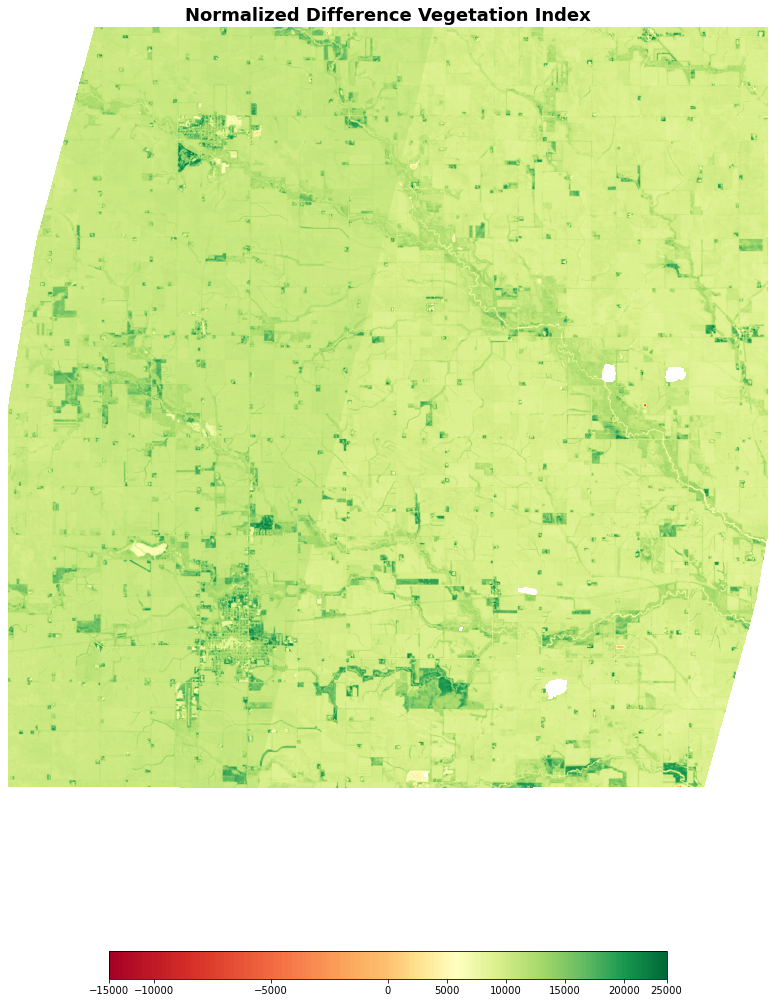

In [360]:

imgfile, udmfile = get_composite_image_and_udm_files(locations)
print("imgfile: ", imgfile)
print("udmfile: ", udmfile)
ndvi = read_ndvi_as_int(imgfile, udmfile)
not_clear = read_notclear(udmfile)
show_ndvi(downsample_img(crop_and_mask(ndvi, not_clear), 4), figsize=(20,20))

Okay, we got some beautiful NDVI images down! Note the UDM2 masking of pixels outside of the footprint and the occasional errant cloud or two.